In [1]:
import pandas as pd
import numpy as np

In [59]:
import statsmodels as sm

In [2]:
from statsmodels.graphics import tsaplots

In [3]:
import sklearn.metrics as metrics

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Loading and cleaning dataset

The data is measured in the same area. The unit for rainfall is mm.

In [5]:
df = pd.read_excel('../dataset/raw_dataset/old/ARRANGEMENT RAINFALL DATA.xlsx', 
                   parse_dates=[0],
                   sheet_name='DAILY', header=1)

df.columns = [col.lower() for col in df.columns]

df = df.sort_values(by='date', ascending=True)

**Verify the dataset contains data for consecutive days**

In [6]:
(df['date'].iloc[-1] - df['date'].iloc[0]).days + 1 == df.shape[0]

True

In [7]:
df = df.set_index('date')

**Splitting the dataset into train and test**

In [8]:
def train_test_split(dataframe, train_ratio=0.8):
    n_train_rows = int(df.shape[0] * train_ratio)
    
    train_values = dataframe.values[:n_train_rows]
    train_index = dataframe.index[:n_train_rows]
    train_df = pd.DataFrame(train_values, columns=dataframe.columns, index=train_index)
    
    test_values = dataframe.values[n_train_rows:]
    test_index = dataframe.index[n_train_rows:]
    test_df = pd.DataFrame(test_values, columns=dataframe.columns, index=test_index)
    
    return train_df, test_df

In [9]:
train_df, test_df = train_test_split(df, 0.8)

**Plot the rainfall by date**

<Figure size 432x288 with 0 Axes>

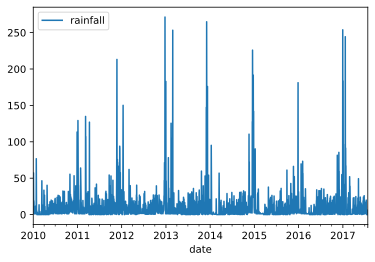

In [10]:
plt.figure(figsize=(6, 4))
train_df.plot()
plt.show()

**Plot autocorrelation**

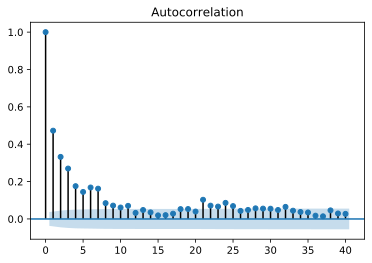

In [11]:
tsaplots.plot_acf(train_df['rainfall'], lags=40)
plt.show()

**Time-series decomposition**

In [61]:
import statsmodels.tsa.seasonal

In [62]:
decomposition = sm.tsa.seasonal.seasonal_decompose(train_df, model='additive')

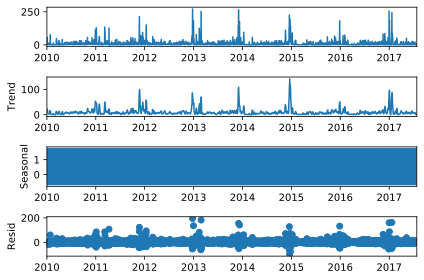

In [63]:
decomposition.plot()
plt.show()

# Modelling

## Autoregressive Integrated Moving Average (ARIMA)

* AR parameter: 8

In [12]:
from statsmodels.tsa.arima_model import ARIMA

In [14]:
ARIMA?

In [13]:
arima_model = ARIMA(endog=train_df, freq='D', order=(8, 1, 0))

In [14]:
arima_model.fit?

In [15]:
arima_model_result = arima_model.fit(disp=0)

In [17]:
residuals = pd.DataFrame(arima_model_result.resid, columns=['residual'])

**Showing line plot of residual errors**

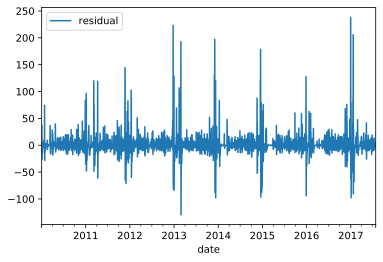

In [18]:
residuals.plot()
plt.show()

**Showing the density plot of the residual errors**

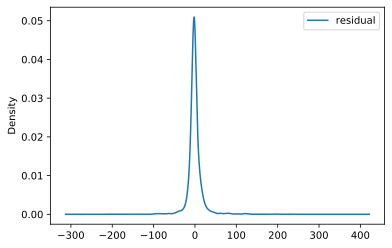

In [19]:
residuals.plot(kind='kde')
plt.show()

In [20]:
residuals.describe()

,residual
count,2763.000000
mean,-0.000888
std,19.465683
min,-129.285064
25%,-5.690360
50%,-1.467175
75%,2.948333
max,237.945484


**Performance on test dataset**

In [21]:
# MAPE is problematic because of division by zero => not using at the moment
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
def cal_performance_metrics(y_true, y_pred):
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true, y_pred)
    return {'mae': mae, 
            'mse': mse,
            'rmse': rmse,
            'r2': r2}

In [48]:
pred, stderr, conf_int = arima_model_result.forecast(steps=test_df.shape[0])

In [49]:
cal_performance_metrics(test_df.values, pred)

{'mae': 10.652111890222203,
 'mse': 366.82061132541844,
 'rmse': 19.152561482094725,
 'r2': -0.43953443669852565}

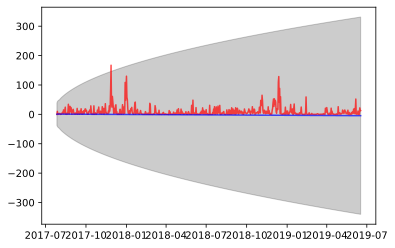

In [58]:
plt.plot(test_df.index, test_df.values, 
         alpha=.7, color='red', label='observed')

plt.plot(test_df.index, pred, alpha=.7, 
         color='blue', label='forecast')

plt.fill_between(test_df.index, conf_int[:, 0], conf_int[:, 1],
                color='k', alpha=.2)

plt.show()